In [1]:
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt

threshold = 0.0001

def weights_diff(model1, model2):
    model_diff = []
    layer_sizes = []
    for i in range(len(model1.layers)):
      if len(model1.layers[i].get_weights()) > 0:
#         print("Layer " + str(i + 1) + ":")
        layer_diff = model1.layers[i].get_weights()[0] - model2.layers[i].get_weights()[0]
        model_diff.append(layer_diff)
#         print(layer_diff)
    for i in range(len(model_diff)):
      current_layer_size = 0
      total_nonzero = 0
      max = 0
      for cell in np.nditer(model_diff[i]):
        current_layer_size += 1
        if abs(cell) > 0.001:
          total_nonzero += 1
          if abs(cell) > max:
            max = cell
      percentage_diff = ((total_nonzero * 1.) / current_layer_size) * 100
      print("Amount of different weights in Layer " + str(i + 1) + ": " + str(total_nonzero)
            + " / " + str(current_layer_size) + " (" + str(percentage_diff) + "%)")
      print("Maximum Difference in Layer " + str(i+1) + ": " + str(max))
      layer_sizes.append(current_layer_size)

        
def weights_diff_stats(model1, model2, threshold):
    model_diff = []
    layer_sizes = []
    for i in range(len(model1.layers)):
      if len(model1.layers[i].get_weights()) > 0:
#         print("Layer " + str(i + 1) + ":")
        layer_diff = model1.layers[i].get_weights()[0] - model2.layers[i].get_weights()[0]
        model_diff.append(layer_diff)
#         print(layer_diff)
    res = []
    for i in range(len(model_diff)):
      current_layer_size = 0
      total_nonzero = 0
      max = 0
      for cell in np.nditer(model_diff[i]):
        current_layer_size += 1
        if abs(cell) > threshold:
          total_nonzero += 1
          if abs(cell) > max:
            max = cell
      percentage_diff = ((total_nonzero * 1.) / current_layer_size) * 100
      res.append(percentage_diff)
#       print("Amount of different weights in Layer " + str(i + 1) + ": " + str(total_nonzero)
#             + " / " + str(current_layer_size) + " (" + str(percentage_diff) + "%)")
#       print("Maximum Difference in Layer " + str(i+1) + ": " + str(max))
      layer_sizes.append(current_layer_size)
    return res

def epoch_weight_diff(m1_prefix, m2_prefix):
    res = []
    for i in [50, 100]:
        t = 'model_ckpt/{}-{}'.format(m1_prefix, str(i).zfill(2))
        s = '{}-{}'.format(m2_prefix, str(i).zfill(2))

        m1 = tf.keras.models.load_model(t)
        m2 = tf.keras.models.load_model(s)

        stats = weights_diff_stats(m1, m2)
        res.append(stats)
    
    lines = []
    for j in range(len(res[0])):
        line = []
        for i in range(len(res)):
            line.append(res[i][j])
        lines.append(line)
    return lines

def single_threshold(th, m1, m2, save=None):
    stats = weights_diff_stats(m1, m2, th)

    fig = plt.figure()
    ax = fig.add_axes([0,0,2,2])
    layers = [f"{i}" for i in range(len(stats))]
    ax.bar(layers,stats)

    ax.set_xlabel("layers")
    ax.set_ylabel('% difference > {}'.format(threshold))

    plt.show()
    if save is not None:
        fig.savefig(save.format(threshold), bbox_inches='tight', dpi=300)

def multiple_thresholds(th, m1, m2, save=None):
#     th = [0.01, 0.001, 0.0001]
    # weights_diff(m1, m2)
    stats = weights_diff_stats(m1, m2, 0.01)
    stats1 = weights_diff_stats(m1, m2, 0.001)
    stats2 = weights_diff_stats(m1, m2, 0.0001)

    st = [stats, stats1, stats2]
    fig, axs = plt.subplots(1,3, figsize=(30, 5), sharex=True, sharey=True)
    for i, ax in enumerate(axs.flat):
        layers = [f"{i}" for i in range(len(st[i]))]
        ax.barh(layers,st[i])
        ax.set_title('Threshold = {}'.format(th[i]))

    # set labels
    plt.setp(axs[:], xlabel='% difference > threshold')
    plt.setp(axs[:], ylabel='Layers')

    fig = plt.figure(figsize=(30,10))

    plt.show()
    if save is not None:
        fig.savefig(save.format(threshold), bbox_inches='tight', dpi=300)

In [2]:
m1 = tf.keras.models.load_model('based_model/based_model-45') # Model trained on all mnist data
m2 = tf.keras.models.load_model('sudden_drift_30000/sudden_drift_30000-45') # m1 trained with first 30000 mnist data with random noise
m3 = tf.keras.models.load_model('mnist_and_30k/mnist_and_30k-45') # Model trained with all mnist data and first 30000 mnist data with random noise
m4 = tf.keras.models.load_model('30k_normal/30k_normal-45') # Model trained on 30k mnist data
m5 = tf.keras.models.load_model('30k_normal_added_10k_mix/30k_normal_added_10k_mix-45') # m4 trained with 10k mix of mnist and noisy

## Experiment 1 - trained with all mnist -> sudden drift of 30k

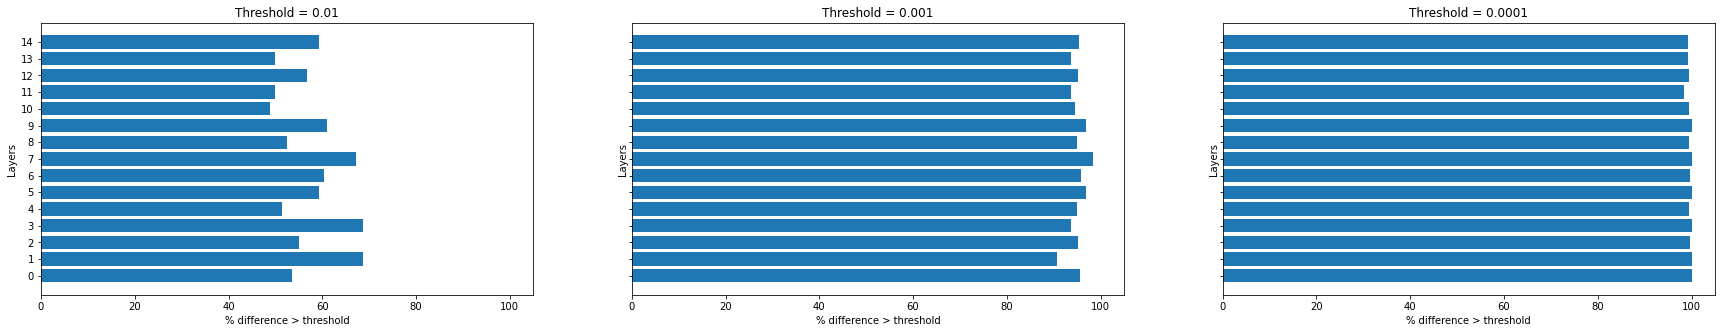

<Figure size 2160x720 with 0 Axes>

In [4]:
multiple_thresholds([0.01, 0.001, 0.0001], m1, m3)

## Eperiment 2 - base model -> (trained with all mnist VS trained with all mnist + 30k noise)

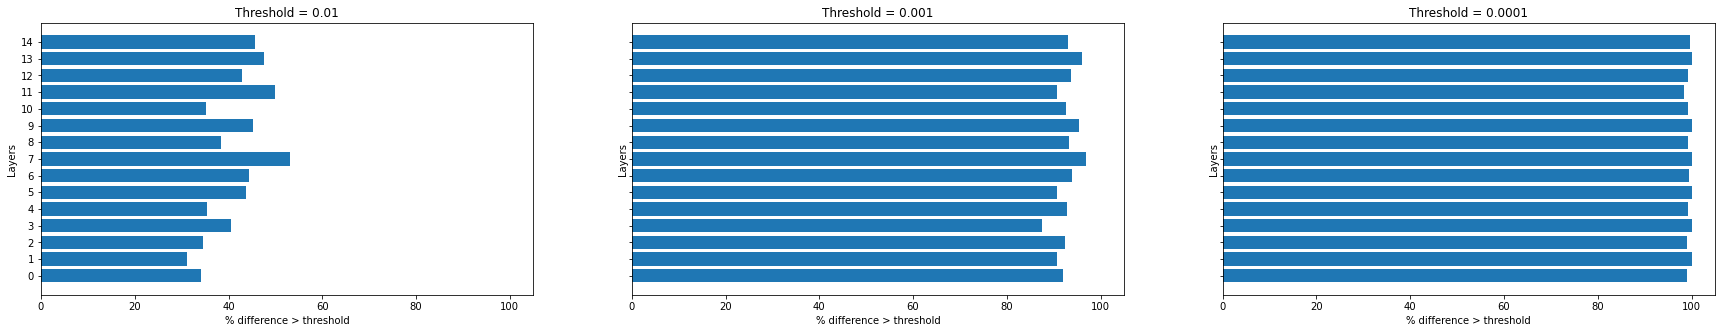

<Figure size 2160x720 with 0 Axes>

In [5]:
multiple_thresholds([0.01, 0.001, 0.0001], m1, m5)

In [6]:
m1 = tf.keras.models.load_model('based_model-45') # Model trained on all mnist data
m4 = tf.keras.models.load_model('30k_normal-45') # Model trained on 30k mnist data
m5 = tf.keras.models.load_model('30k_normal_added_10k_mix-45') # m4 trained with 10k mix of mnist and noisy

## Eperiment 3 - trained with all mnist -> more 30k mnist (duplicates)

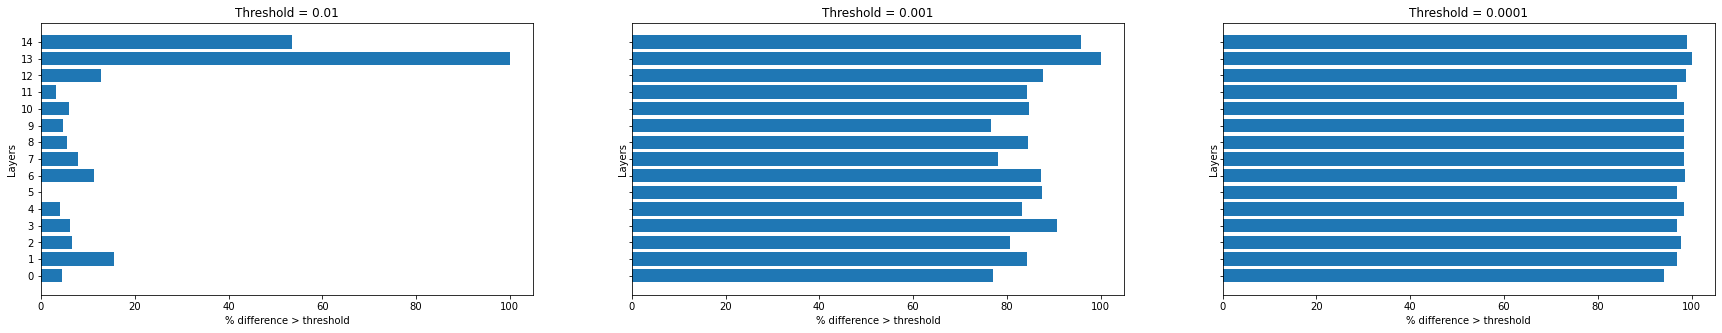

<Figure size 2160x720 with 0 Axes>

In [7]:
multiple_thresholds([0.01, 0.001, 0.0001], m1, m4)

## Eperiment 4 - trained with all mnist -> more 30k mnist (duplicates) -> more 5k mnist + 5k noisy

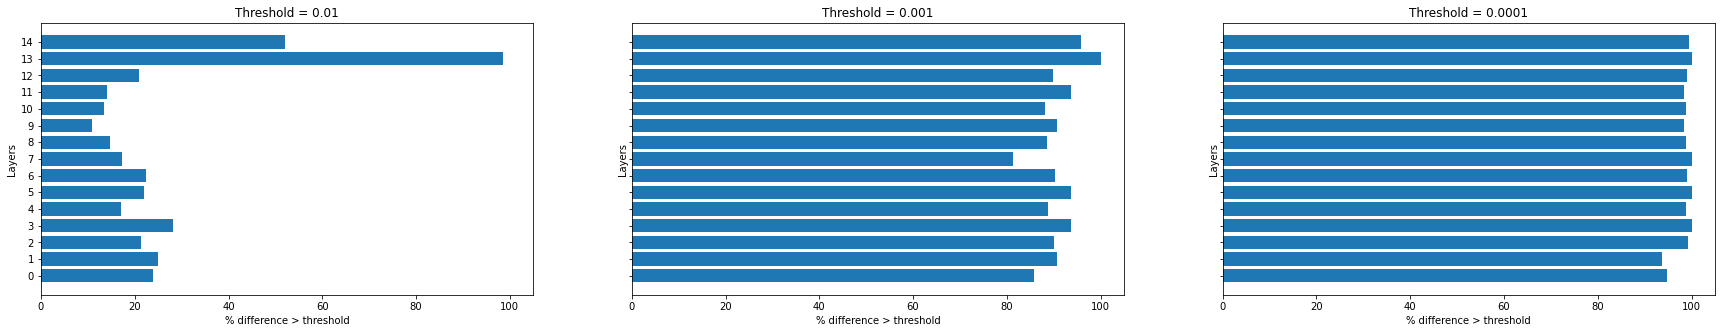

<Figure size 2160x720 with 0 Axes>

In [8]:
multiple_thresholds([0.01, 0.001, 0.0001], m1, m5)